# MCLP
$$Maximize \sum_{i \in I} w_iy_i $$
$$s.t \quad  y_i \leq \sum_{j \in N_i}x_j \quad for \, all \quad i \in I$$
$$ \sum_{j \in J}x_j = K $$
$$x_j,y_i \in {0,1} \quad for \, all \quad i \in I,j \in J$$

|문자|의미|
|-|-|
|i|수요 포인트 index|
|j|설비지역 포인트 index|
|I|수요 포인트 집합|
|J|설비지역 포인트 집합|
|K|설치해야하는 설비 개수|
|x|설비 후보 지역 중 위치 j 에 설치되면 1, 아니면 0|
|y|적어도 하나의 설비로 그 포인트가 커버되면 1, 아니면 0|
|w|입지 선정 지수=가중치|

## [공간최적화 참조 코드](https://pysal.org/spaghetti/notebooks/facility-location.html)

# 모듈 불러오기

In [2]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력
from IPython.display import HTML #출력 결과를 HTML로 생성

In [3]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

# 한글폰트
import os
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

import numpy as np
import folium

In [4]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

# Define a Class and functions

In [171]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship folowing optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )


In [172]:
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [173]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1,color='dimgray')
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv))
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [174]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=True)

In [175]:
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )

In [176]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [177]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [225]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "aqua",
        "crimson",
        "cyan",
        "limegreen",
        "snow",
        "mintcream",
        "lemonchiffon",
        "lightcoral",
        "peachpuff",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "rebeccapurple",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',    
    ]
    

    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    print(dv_colors)
    return dv_colors

In [220]:
import random

In [13]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

### 픽셀 사이즈 떄문에 에러 발생시켜서 사용하지 않음
```
def add_legend(patches, for_multiplot=False):
    
    Add a legend to a plot
    Parameters
    ----------
    patches : list
        legend handles matching plotted items
    for_multiplot : create_patches
    
    if for_multiplot:
        anchor = (1.1, 1.65)
    else:
        anchor = (1.005, 1.016)
    legend = plt.legend(
        handles=patches,
        loc="upper left",
        fancybox=True,
        framealpha=0.85,
        bbox_to_anchor=anchor,
        fontsize="x-large",
        labelspacing=1.5,
        borderpad=2.
    )
    legend.get_frame().set_facecolor("white")
```

## Utilizing libpysal.cg.alpha_shapes

In [179]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [180]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [181]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [182]:
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style


# Geopandas Data
## 서울시 shp
- road = 도로 shape파일  
- emd = 읍면동 shape파일  
- sig = 시군구 shape파일

In [19]:
# 도로shp 파일 불러오기
road = geopandas.read_file('DataSet\Z_KAIS_TL_SPRD_MANAGE_서울\Z_KAIS_TL_SPRD_MANAGE_11000.shp',encoding = 'ANSI')
#SHP 파일 geometry 좌표변환
road = road.to_crs(epsg=5179)

In [20]:
emd = geopandas.read_file('dataset\EMD_20220324\emd.shp', encoding = 'euc-kr')
emd = emd.to_crs(epsg=4326)
sig = geopandas.read_file('dataset\SIG_20220324\sig.shp', encoding = 'euc-kr')
sig = sig.to_crs(epsg=4326)

seoul_EMD = emd[emd['EMD_CD'].str.startswith('11')]
seoul_sig = sig[sig['SIG_CD'].str.startswith('11')]
seoul_EMD = seoul_EMD.to_crs({'init':'epsg:5179'})
seoul_sig = seoul_sig.to_crs({'init':'epsg:5179'})

In [69]:
seoul_sig

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."
5,11230,Dongdaemun-gu,동대문구,"POLYGON ((962141.919 1956519.461, 962149.853 1..."
6,11260,Jungnang-gu,중랑구,"POLYGON ((965698.531 1957987.355, 965772.290 1..."
7,11290,Seongbuk-gu,성북구,"POLYGON ((956787.318 1953542.506, 956761.258 1..."
8,11305,Gangbuk-gu,강북구,"POLYGON ((956316.789 1965175.345, 956401.551 1..."
9,11320,Dobong-gu,도봉구,"POLYGON ((957223.835 1961199.545, 957195.758 1..."


## 서울시 편의점 위치
- 파일 불러오기
- geodf 변환

In [ ]:
# pharmacy = pd.read_csv('DataSet\서울시 약국 운영시간 정보.csv',encoding='ANSI')
# pharmacy.head(1)
# #가져온 데이터가 기존에 5179좌표계여서 set_crs만 진행
# pharmacy = geopandas.GeoDataFrame(pharmacy, geometry=geopandas.points_from_xy(pharmacy['병원경도'], pharmacy['병원위도']))
# pharmacy.head(2)
# pharmacy.crs = {'init':'epsg:4326'}
# pharmacy = pharmacy.to_crs({'init':'epsg:5179'})

## 공공공지 facility

In [ ]:
convenience = pd.read_csv('PreprocessData\convenience.csv')
convenience = geopandas.GeoDataFrame(convenience)
convenience = convenience.drop(['Unnamed: 0', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자', '영업상태코드', '영업상태명',
       '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자', '재개업일자', '전화번호',
       '소재지면적', '소재지우편번호', '지번주소', '최종수정일자',
       '데이터갱신구분', '데이터갱신일자'], axis=1)
convenience = geopandas.GeoDataFrame(convenience, geometry=geopandas.points_from_xy(convenience['좌표정보(X)'], convenience['좌표정보(Y)']))
convenience.crs = {'init':'epsg:2097'}
convenience = convenience.to_crs({'init':'epsg:5179'})
convenience = geopandas.sjoin(seoul_sig, convenience, how='right', op="contains")
convenience = convenience.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)
convenience.head(5)

gong = pd.read_csv('PreprocessData\pharmacy.csv')
gong = geopandas.GeoDataFrame(gong)
gong = gong.drop(['Unnamed: 0', 'index', '작업일시'], axis=1)
gong = geopandas.GeoDataFrame(gong, geometry=geopandas.points_from_xy(gong['병원경도'], gong['병원위도']))
gong.crs = {'init':'epsg:4326'}
gong = gong.to_crs({'init':'epsg:5179'})
gong = geopandas.sjoin(seoul_sig, gong, how='right', op="contains")
gong = gong.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)

# 입지모델 
## 강남구

In [ ]:
convenience = pd.read_csv('PreprocessData\convenience.csv')
convenience = geopandas.GeoDataFrame(convenience)
convenience = convenience.drop(['Unnamed: 0', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자', '영업상태코드', '영업상태명',
       '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자', '재개업일자', '전화번호',
       '소재지면적', '소재지우편번호', '지번주소', '최종수정일자',
       '데이터갱신구분', '데이터갱신일자'], axis=1)
convenience = geopandas.GeoDataFrame(convenience, geometry=geopandas.points_from_xy(convenience['좌표정보(X)'], convenience['좌표정보(Y)']))
convenience.crs = {'init':'epsg:2097'}
convenience = convenience.to_crs({'init':'epsg:5179'})
convenience = geopandas.sjoin(seoul_sig, convenience, how='right', op="contains")
convenience = convenience.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)
convenience.head(5)

gong = pd.read_csv('PreprocessData\pharmacy.csv')
gong = geopandas.GeoDataFrame(gong)
gong = gong.drop(['Unnamed: 0', 'index', '작업일시'], axis=1)
gong = geopandas.GeoDataFrame(gong, geometry=geopandas.points_from_xy(gong['병원경도'], gong['병원위도']))
gong.crs = {'init':'epsg:4326'}
gong = gong.to_crs({'init':'epsg:5179'})
gong = geopandas.sjoin(seoul_sig, gong, how='right', op="contains")
gong = gong.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)

### 구 추출
- 행정구 코드 베이스로 추출 진행

In [55]:
gangnam_streets = road[road['SIG_CD'].str.startswith('11680')]

In [140]:
gangnam_clients = file[file['SIG_KOR_NM']=='강남구']
gangnam_clients.shape

(593, 9)

In [157]:
gangnam_facility = gong[gong['SIG_KOR_NM']=='강남구']

In [212]:
gangnam_clients

,SIG_KOR_NM,도로명주소,도로명우편번호,사업장명,업태구분명,좌표정보(X),좌표정보(Y),판매점영업면적,geometry,dv,weight,mclp_sol
3162,강남구,서울특별시 강남구 언주로168길 38 1층 (신사동),6020.0,지에스25 신사장터점,NaN,203172.134325,447064.234476,NaN,POINT (958805.193 1947492.039),x[0],1,[y[1]]
4076,강남구,서울특별시 강남구 자곡로 201 강남 더샵 라르고 1층 101102호일부104호 (...,6372.0,지에스25 자곡라르고점,NaN,209205.687911,441478.676729,NaN,POINT (964806.562 1941876.614),x[1],1,closed
5776,강남구,서울특별시 강남구 학동로38길 40 1층 (논현동),6106.0,이마트24 논현행운점,NaN,202980.594521,445559.690587,81.16,POINT (958605.715 1945989.120),x[2],1,[y[398]]
5777,강남구,서울특별시 강남구 봉은사로43길 21 (논현동),6102.0,(주)코리아세븐논현경복점,NaN,203413.921695,445374.800363,0.00,POINT (959037.884 1945801.996),x[3],1,[y[60]]
5778,강남구,서울특별시 강남구 영동대로137길 6 1층 (청담동),6072.0,씨유 청담파라곤점,NaN,204785.799893,446658.175155,0.00,POINT (960416.046 1947077.546),x[4],1,[y[1]]
...,...,...,...,...,...,...,...,...,...,...,...,...
7392,강남구,서울특별시 강남구 봉은사로37길 13 1층 (논현동),6109.0,GS25 논현동우점,NaN,203156.329796,445218.330143,NaN,POINT (958779.562 1945646.960),x[588],1,"[y[1], y[84]]"
7409,강남구,서울특별시 강남구 선릉로86길 31 롯데골드로즈2 1층 101호 (대치동),6193.0,세븐일레븐 골드로즈점,NaN,204536.822021,444660.784269,NaN,POINT (960156.529 1945082.286),x[589],1,"[y[1], y[84]]"
7433,강남구,서울특별시 강남구 언주로30길 21 상가에이동 1층 105-2호 (도곡동 아카데미스위트),6292.0,지에스25 도곡아카데미점,NaN,204538.144892,442942.853505,NaN,POINT (960148.705 1943365.041),x[590],1,[y[60]]
7448,강남구,서울특별시 강남구 강남대로102길 40 1층 (역삼동),6128.0,GS25강남아트점,NaN,202440.761304,444579.973957,NaN,POINT (958060.881 1945012.671),x[591],1,[y[425]]


<AxesSubplot:>

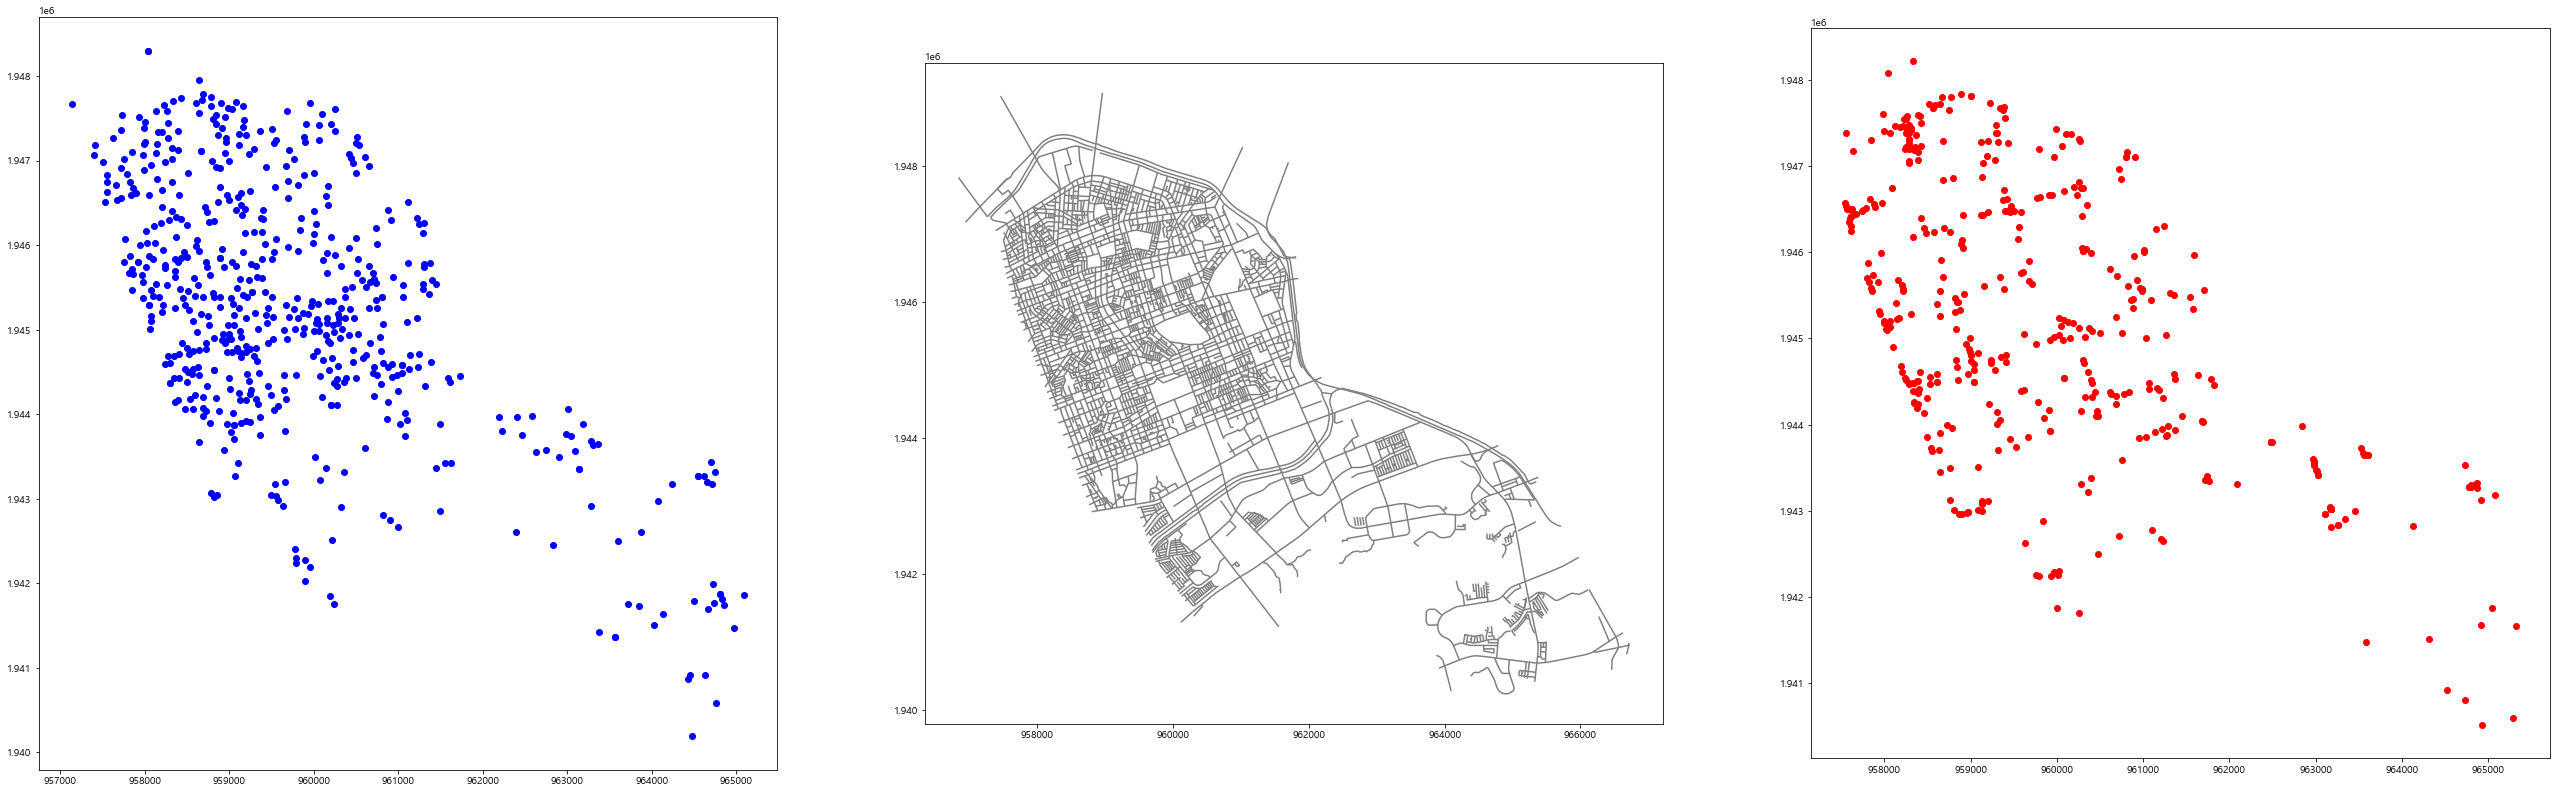

In [158]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
gangnam_clients.plot(color='blue',ax=ax[0])
gangnam_streets.plot(color='grey',ax=ax[1])
gangnam_facility.plot(color='red',ax=ax[2])

### 세팅

In [216]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gangnam_clients.shape[0],gangnam_facility.shape[0]
# plot 제목
title = "Gangnam Neighborhood X"

In [217]:
buff = 20
streets_buffer = get_buffer(gangnam_streets, buff=buff)

In [218]:
streets = gangnam_streets
#구분자 삽입
clients = gangnam_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]
#구분자 삽입
facilities = gangnam_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head())

,SIG_KOR_NM,도로명주소,도로명우편번호,사업장명,업태구분명,좌표정보(X),좌표정보(Y),판매점영업면적,geometry,dv,weight,mclp_sol
3162,강남구,서울특별시 강남구 언주로168길 38 1층 (신사동),6020.0,지에스25 신사장터점,NaN,203172.134325,447064.234476,NaN,POINT (958805.193 1947492.039),x[0],1,[y[1]]
4076,강남구,서울특별시 강남구 자곡로 201 강남 더샵 라르고 1층 101102호일부104호 (...,6372.0,지에스25 자곡라르고점,NaN,209205.687911,441478.676729,NaN,POINT (964806.562 1941876.614),x[1],1,closed


,SIG_KOR_NM,약국ID,주소,약국명,대표전화1,진료시간(월요일)C,진료시간(화요일)C,진료시간(수요일)C,진료시간(목요일)C,진료시간(금요일)C,...,진료시간(토요일)S,진료시간(일요일)S,진료시간(공휴일)S,우편번호1,우편번호2,병원경도,병원위도,geometry,dv,mclp_sol
7,강남구,C1102142,서울특별시 강남구 압구정로 336 (신사동),감마약국,02-547-8990,2100,2100,2100,2100,2100,...,900,900.0,900.0,60,18,127.038478,37.528021,POINT (959221.208 1947735.105),y[0],closed
11,강남구,C1109043,서울특별시 강남구 학동로 지하 346 강남구청역 B1층 111호 (삼성동),강남구청역약국,02-511-6252,2100,2100,2100,2100,2100,...,900,900.0,900.0,60,99,127.041301,37.517189,POINT (959464.782 1946532.160),y[1],"[x[0], x[4], x[5], x[6], x[9], x[11], x[12], x..."
12,강남구,C1107162,서울특별시 강남구 남부순환로 2615 (도곡동) 극동스타클래스208호,강남굿모닝약국,02-529-4155,2000,2000,2000,2000,2000,...,940,900.0,900.0,62,67,127.035869,37.485192,POINT (958967.250 1942984.592),y[2],closed
13,강남구,C1108644,서울특별시 강남구 헌릉로 569 1층 105호 (세곡동),강남리더스약국,02-3414-8001,1930,2000,1930,1930,2000,...,900,900.0,900.0,63,76,127.101226,37.465758,POINT (964736.191 1940802.084),y[3],[x[467]]
14,강남구,C1103021,서울특별시 강남구 삼성로 233 (대치동),강남메디칼약국,02-568-6644,1900,1900,1900,1900,1900,...,900,900.0,900.0,62,79,127.060899,37.498055,POINT (961186.763 1944401.079),y[4],closed


NameError: name 'add_legend' is not defined

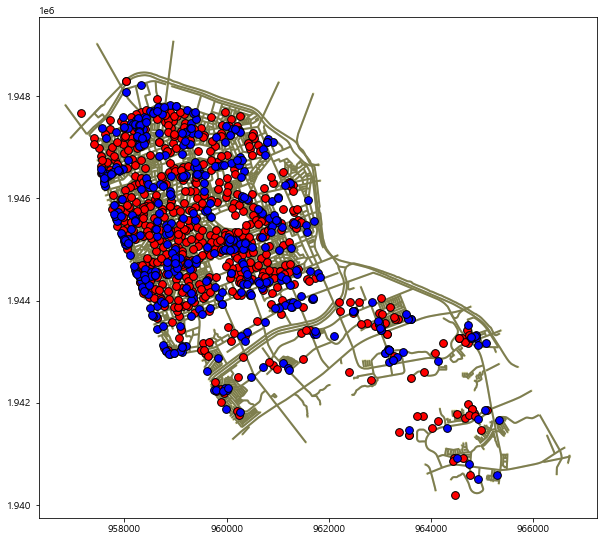

In [219]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}

plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60,figsize=(10,10))

### 모델링

In [164]:
# 네트워크 불러오기
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [165]:
# Cost Matrix 계산 시간 소요
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

array([[ 649.84273302, 1520.76180136, 5681.42344821],
       [          inf,           inf,           inf],
       [          inf,           inf,           inf]])

In [190]:
clients["weight"] = 1
clients

,SIG_KOR_NM,도로명주소,도로명우편번호,사업장명,업태구분명,좌표정보(X),좌표정보(Y),판매점영업면적,geometry,dv,weight
3162,강남구,서울특별시 강남구 언주로168길 38 1층 (신사동),6020.0,지에스25 신사장터점,NaN,203172.134325,447064.234476,NaN,POINT (958805.193 1947492.039),x[0],1
4076,강남구,서울특별시 강남구 자곡로 201 강남 더샵 라르고 1층 101102호일부104호 (...,6372.0,지에스25 자곡라르고점,NaN,209205.687911,441478.676729,NaN,POINT (964806.562 1941876.614),x[1],1
5776,강남구,서울특별시 강남구 학동로38길 40 1층 (논현동),6106.0,이마트24 논현행운점,NaN,202980.594521,445559.690587,81.16,POINT (958605.715 1945989.120),x[2],1
5777,강남구,서울특별시 강남구 봉은사로43길 21 (논현동),6102.0,(주)코리아세븐논현경복점,NaN,203413.921695,445374.800363,0.00,POINT (959037.884 1945801.996),x[3],1
5778,강남구,서울특별시 강남구 영동대로137길 6 1층 (청담동),6072.0,씨유 청담파라곤점,NaN,204785.799893,446658.175155,0.00,POINT (960416.046 1947077.546),x[4],1
...,...,...,...,...,...,...,...,...,...,...,...
7392,강남구,서울특별시 강남구 봉은사로37길 13 1층 (논현동),6109.0,GS25 논현동우점,NaN,203156.329796,445218.330143,NaN,POINT (958779.562 1945646.960),x[588],1
7409,강남구,서울특별시 강남구 선릉로86길 31 롯데골드로즈2 1층 101호 (대치동),6193.0,세븐일레븐 골드로즈점,NaN,204536.822021,444660.784269,NaN,POINT (960156.529 1945082.286),x[589],1
7433,강남구,서울특별시 강남구 언주로30길 21 상가에이동 1층 105-2호 (도곡동 아카데미스위트),6292.0,지에스25 도곡아카데미점,NaN,204538.144892,442942.853505,NaN,POINT (960148.705 1943365.041),x[590],1
7448,강남구,서울특별시 강남구 강남대로102길 40 1층 (역삼동),6128.0,GS25강남아트점,NaN,202440.761304,444579.973957,NaN,POINT (958060.881 1945012.671),x[591],1


In [191]:
mclp = FacilityLocationModel("mclp", ai=clients["weight"], cij=cost_matrix, p=1, s=1000)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.0520167707 minutes
Obj. Value: 94.0 residents within 1000.000000 meters of 1 selected facilities
Percent of 593 clients covered: 15.851602
--- 499 clients are not covered
--- 94 clients are covered by 1 facility


IndexError: list index out of range

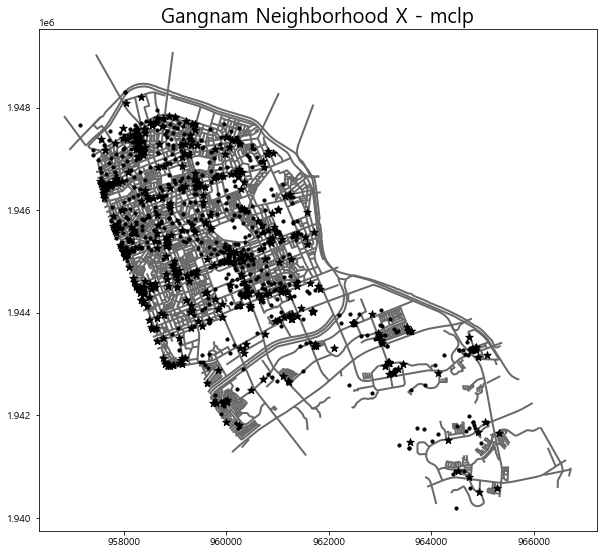

In [192]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [193]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

ValueError: `caption` must be either a string or 2-tuple of strings.

In [195]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weight"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.0477500955 minutes
Obj. Value: 288.0 residents within 2000.000000 meters of 1 selected facilities
Percent of 593 clients covered: 48.566610
--- 305 clients are not covered
--- 288 clients are covered by 1 facility


IndexError: list index out of range

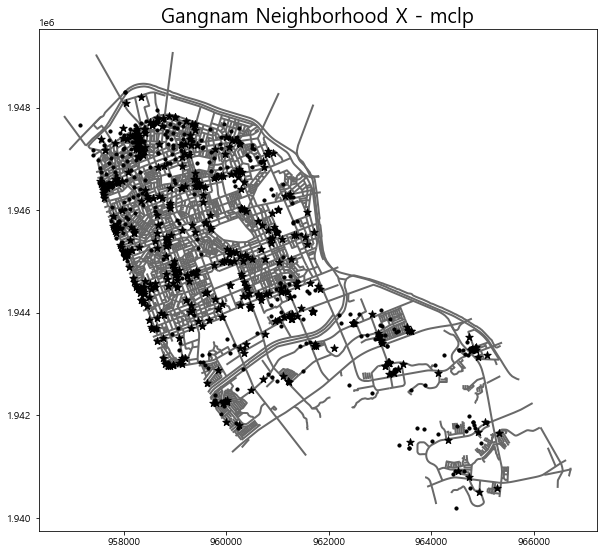

In [196]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [202]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

ValueError: `caption` must be either a string or 2-tuple of strings.

In [209]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weight"], cij=cost_matrix, p=20, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.054733442800000004 minutes
Obj. Value: 566.0 residents within 3000.000000 meters of 20 selected facilities
Percent of 593 clients covered: 95.446880
--- 27 clients are not covered
--- 566 clients are covered by 1 facility
--- 226 clients are covered by 2 facilities


IndexError: list index out of range

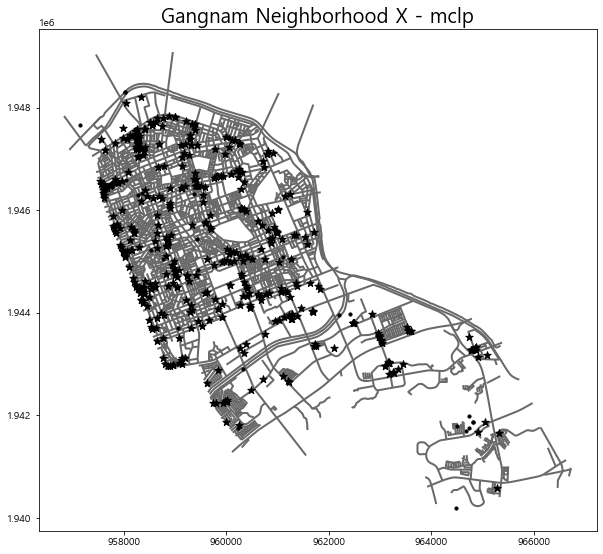

In [226]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [206]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

ValueError: `caption` must be either a string or 2-tuple of strings.

## 강동구
### 구 추출

In [ ]:
gangdong_streets = road[road['SIG_CD'].str.startswith('11740')]

In [ ]:
gangdong_clients = fdshop[fdshop['sigungu']=='강동구']
gangdong_clients.shape

In [ ]:
gangdong_facility = gong[gong['hangjunggu']=='강동구']

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
gangdong_clients.plot(color='blue',ax=ax[0])
gangdong_streets.plot(color='grey',ax=ax[1])
gangdong_facility.plot(color='red',ax=ax[2])

### 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gangdong_clients.shape[0],gangdong_facility.shape[0]
# plot 제목
title = "Gangdong Neighborhood X"

In [ ]:
buff = 20
streets_buffer = get_buffer(gangdong_streets, buff=buff)

In [ ]:
streets = gangdong_streets

clients = gangdong_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = gangdong_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

### 모델링

In [ ]:
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

#### MCLP

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

## 동작구
### 구추출

In [ ]:
dongjak_streets = road[road['SIG_CD'].str.startswith('11590')]

In [ ]:
dongjak_clients = fdshop[fdshop['sigungu']=='동작구']

In [ ]:
dongjak_facility = gong[gong['hangjunggu']=='동작구']

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
dongjak_clients.plot(color='blue',ax=ax[0])
dongjak_streets.plot(color='grey',ax=ax[1])
dongjak_facility.plot(color='red',ax=ax[2])

### 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = dongjak_clients.shape[0],dongjak_facility.shape[0]

#plot 제목
title = "Dongjak Neighborhood X"

In [ ]:
buff = 20
streets_buffer = get_buffer(dongjak_streets, buff=buff)

In [ ]:
streets = dongjak_streets

clients = dongjak_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = dongjak_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

In [ ]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}

plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60,figsize=(10,10))

### 모델링

In [ ]:
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

#### MCLP

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

## 송파구
### 구 추출

In [ ]:
songpa_streets = road[road['SIG_CD'].str.startswith('11710')]

In [ ]:
songpa_clients = fdshop[fdshop['sigungu']=='송파구']
songpa_clients.shape

In [ ]:
songpa_facility = gong[gong['hangjunggu']=='송파구']

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
songpa_clients.plot(color='blue',ax=ax[0])
songpa_streets.plot(color='grey',ax=ax[1])
songpa_facility.plot(color='red',ax=ax[2])

### 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = songpa_clients.shape[0],songpa_facility.shape[0]

#plot 제목
title = "Songpa Neighborhood X"

In [ ]:
buff = 20
streets_buffer = get_buffer(songpa_streets, buff=buff)

In [ ]:
streets = songpa_streets

clients = songpa_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = songpa_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

### 모델링

In [ ]:
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

#### MCLP

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1500
)
clients, facilities = add_results(mclp, clients, facilities)
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

## 관악구
### 구추출

In [ ]:
gwan_streets = road[road['SIG_CD'].str.startswith('11620')]

In [ ]:
gwan_clients = fdshop[fdshop['sigungu']=='관악구']
gwan_clients.shape

In [ ]:
gwan_facility = gong[gong['hangjunggu']=='관악구']

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
gwan_clients.plot(color='blue',ax=ax[0])
gwan_streets.plot(color='grey',ax=ax[1])
gwan_facility.plot(color='red',ax=ax[2])

### 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gwan_clients.shape[0],gwan_facility.shape[0]

# plot 제목
title = "Gwanak Neighborhood X"

In [ ]:
buff = 20
streets_buffer = get_buffer(gwan_streets, buff=buff)

In [ ]:
streets = gwan_streets

clients = gwan_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = gwan_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

### 모델링 

In [ ]:
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

#### MCLP

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

## 영등포구
### 구 추출

In [ ]:
yung_streets = road[road['SIG_CD'].str.startswith('11560')]

In [ ]:
yung_clients = fdshop[fdshop['sigungu']=='영등포구']
yung_clients.shape

In [ ]:
yung_facility = gong[gong['hangjunggu']=='영등포구']

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
yung_clients.plot(color='blue',ax=ax[0])
yung_streets.plot(color='grey',ax=ax[1])
yung_facility.plot(color='red',ax=ax[2])

### 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = yung_clients.shape[0],yung_facility.shape[0]

# plot 제목
title = "Yeongdeungpo Neighborhood X"

In [ ]:
buff = 20
streets_buffer = get_buffer(yung_streets, buff=buff)

In [ ]:
streets = yung_streets

clients = yung_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = yung_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

### 모델링

In [ ]:
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

#### MCLP

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

## 강서구
### 구 추출

In [ ]:
gangsu_streets = road[road['SIG_CD'].str.startswith('11500')]

In [ ]:
gangsu_clients = fdshop[fdshop['sigungu']=='강서구']
gangsu_clients.shape

In [ ]:
gangsu_facility = gong[gong['hangjunggu']=='강서구']

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
gangsu_clients.plot(color='blue',ax=ax[0])
gangsu_streets.plot(color='grey',ax=ax[1])
gangsu_facility.plot(color='red',ax=ax[2])

### 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gangsu_clients.shape[0],gangsu_facility.shape[0]

# plot 제목
title = "Gangsu Neighborhood X"

In [ ]:
buff = 20
streets_buffer = get_buffer(gangsu_streets, buff=buff)

In [ ]:
streets = gangsu_streets

clients = gangsu_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]

facilities = gangsu_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head(3))

### 모델링

In [ ]:
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

In [ ]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
    "cli_snp": clients_snapped,
    "fac_snp": facilities_snapped,
}
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, pt2_size=10)

#### MCLP

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])